In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.data_transform import log_moulus_nfold
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid, GRID_SHAPE
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

isCNN = True
isTrain = True

## Load simulation data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_tuftsyn_trunkLR4_LactvCa_Loc5_restrict_h')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

if isCNN:
    LFP = np.load(LFP_PATH)
    lfp = LFP['x'] * 1000 # convert to uV
    labels = LFP['y'][LFP['good_indices']]
    ys = LFP['ys']
else:
    STATS = np.load(STATS_PATH)
    summ_stats = STATS['x']
    labels = STATS['y']
    ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt,vx,vy,vz
1081,-147.855483,184.994413,0.720290,264.780053,0.230219,0.514903,0.483891,-0.081333,0.995407,0.050497
1844,-144.568672,137.919096,-0.034289,403.968737,0.048808,0.417666,0.654134,-0.368391,0.925337,-0.089665
235,-143.514708,185.898467,-0.187669,139.375047,0.277484,0.561263,0.401786,0.004468,0.986492,0.163750
5295,-139.529770,181.434084,-0.033181,1035.302760,0.037441,0.529719,0.457543,-0.592786,0.733133,0.333347
3117,-138.513753,189.364199,0.141048,366.805746,0.204434,0.490088,0.567057,0.330516,0.941004,0.072598
...,...,...,...,...,...,...,...,...,...,...
5234,652.263377,167.862841,0.041874,479.157826,0.086260,0.626195,0.460874,0.112085,0.976599,-0.183554
2385,681.550121,192.360311,0.161719,657.951680,0.126639,0.406432,0.675729,-0.110994,0.966831,-0.230038
2819,690.847460,192.531412,-0.160088,504.497049,0.021935,0.625659,0.527698,0.038863,0.992983,-0.111689
5437,990.115337,165.891330,0.223197,802.774247,0.106695,0.596236,0.469159,-0.062426,0.995935,-0.064928


### Normalizing labels

#### Set bounds for y shift

In [5]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))

print(json.dumps(ranges))

16.21% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [100.0, 1200.0], "lr_pt": [0.02, 0.35], "r_t": [0.4, 1.5], "rr_dt": [0.4, 0.8], "vx": [-1.0, 1.0], "vy": [-1.0, 1.0], "vz": [-1.0, 1.0], "ys": [-150, 150]}


#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt,vx,vy,vz
0,0.074537,-0.545328,0.037867,-0.223231,-0.077687,-0.024546,-0.216148,-0.138682,0.860801,0.489683
1,-0.104889,-0.366483,0.533298,-0.223231,-0.077687,-0.024546,-0.216148,0.662879,0.740817,-0.108540
2,-0.114939,0.594731,-0.118573,-0.223231,-0.077687,-0.024546,-0.216148,-0.233748,0.905104,0.355175
3,-0.265067,0.352509,-0.009053,-0.223231,-0.077687,-0.024546,-0.216148,-0.179952,0.720016,0.670220
4,0.697620,-0.217781,-0.441136,-0.223231,-0.077687,-0.024546,-0.216148,0.144645,0.820484,-0.553067
...,...,...,...,...,...,...,...,...,...,...
5971,-0.042130,-0.160493,-0.834186,0.374033,0.452406,0.535987,0.419625,-0.336148,0.938450,0.079471
5972,1.092661,-0.212319,0.047885,0.374033,0.452406,0.535987,0.419625,-0.310209,0.882788,-0.352782
5973,-0.189110,-0.082288,0.185007,0.374033,0.452406,0.535987,0.419625,0.591362,0.804725,-0.052043
5974,1.275133,0.841172,-0.103618,0.374033,0.452406,0.535987,0.419625,-0.141611,0.840166,-0.523514


## Build model

In [7]:
if isCNN:
    n_fold = 30
    max_logmod = np.ceil(np.log2(n_fold))  # max value after transform
    n_fold = 2**max_logmod - 1
    
    lfp_trans = np.empty_like(lfp)
    for i in range(lfp.shape[0]):
        lfp_trans[i] = log_moulus_nfold(lfp[i], n_fold)
    
    lfp_trans = np.stack((lfp, lfp_trans), axis=1)
    lfp_trans = lfp_trans.reshape(lfp_trans.shape[:3] + (GRID_SHAPE[0], -1))

In [8]:
import torch

batch_size = 256
model_name = '_batch' + str(batch_size)

if isCNN:
    from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork, ActivationTypes
    model_name = 'CNN' + model_name
    num_filters = [8, 16, 16, 32, 32, 64, 64, 64, 32, 8]
    model = ConvolutionalNetwork(in_channels=lfp_trans.shape[1], out_features=len(label_list), num_filters=num_filters)
else:
    from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
    model_name = 'FCN' + model_name
    model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=len(label_list))

if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)
if isTrain and not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print("The new model directory is created!")

PARAM_PATH = os.path.join(MODEL_PATH, model_name + '.pth')
SAVE_PATH = os.path.join(MODEL_PATH, model_name + '.txt')

The new model directory is created!


## Train model

In [9]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

if isCNN:
    train_size = 0.8 if isTrain else 0.
    train_loader, test_loader = build_dataloader_from_numpy(
        input_arr=lfp_trans, labels_arr=labels, batch_size=batch_size, train_size=train_size, shuffle=True
    )
else:
    train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=batch_size, shuffle=True)

if isTrain:
    history, files = train_regression(model, train_loader, test_loader, epochs=100, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), PARAM_PATH)
    with open(SAVE_PATH, 'w') as f:
        f.writelines(s + '\n' for s in files)

  2%|▊                                         | 2/100 [00:00<00:24,  3.94it/s]

Training Loss: 5.62096843123436 Validation Loss: 1.2035674303770065


 11%|████▌                                    | 11/100 [00:02<00:20,  4.32it/s]

Training Loss: 2.538357585668564 Validation Loss: 0.6582543402910233


 22%|█████████                                | 22/100 [00:05<00:18,  4.23it/s]

Training Loss: 2.143081896007061 Validation Loss: 0.5663264244794846


 31%|████████████▋                            | 31/100 [00:07<00:14,  4.83it/s]

Training Loss: 2.0270833149552345 Validation Loss: 0.5439915433526039


 41%|████████████████▊                        | 41/100 [00:09<00:14,  3.94it/s]

Training Loss: 1.9093143343925476 Validation Loss: 0.5154928341507912


 51%|████████████████████▉                    | 51/100 [00:12<00:11,  4.27it/s]

Training Loss: 1.8295572325587273 Validation Loss: 0.49862726777791977


 61%|█████████████████████████                | 61/100 [00:14<00:11,  3.40it/s]

Training Loss: 1.747339017689228 Validation Loss: 0.47629449516534805


 71%|█████████████████████████████            | 71/100 [00:17<00:06,  4.33it/s]

Training Loss: 1.6914117112755775 Validation Loss: 0.4647150933742523


 81%|█████████████████████████████████▏       | 81/100 [00:19<00:04,  4.00it/s]

Training Loss: 1.6533564552664757 Validation Loss: 0.455697201192379


 91%|█████████████████████████████████████▎   | 91/100 [00:22<00:02,  3.76it/s]

Training Loss: 1.6294419392943382 Validation Loss: 0.44926293939352036


100%|████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]


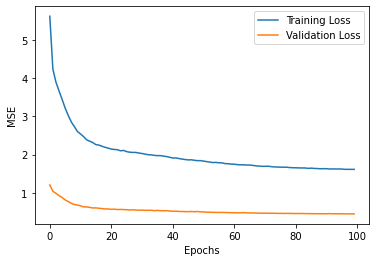

In [10]:
if not isTrain:
    with open(SAVE_PATH, 'r') as f:
        loss_file = f.read().splitlines()[1]
        loss_file = loss_file.split(os.path.sep)[-1].split('/')[-1]
        loss_file = os.path.join(paths.LOSSES_ROOT, loss_file)
    history = pd.read_csv(loss_file).to_dict(orient='list')
plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Evaluate model

### Perform on stylized model

In [11]:
from sklearn.metrics import r2_score
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device('cpu')
if not isTrain:
    model.load_state_dict(torch.load(PARAM_PATH, map_location=torch.device('cpu')))
model.to(device)
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

R2 Score:
y-shift,   0.918
d,         0.916
theta,     0.619
l_t,       0.643
lr_pt,     0.335
r_t,       0.897
rr_dt,     0.039
vx,        0.594
vy / h,    -0.537
vz,        0.679
phi,       0.185


Stylized Cell Testing Data: Ground Truth VS Predicted


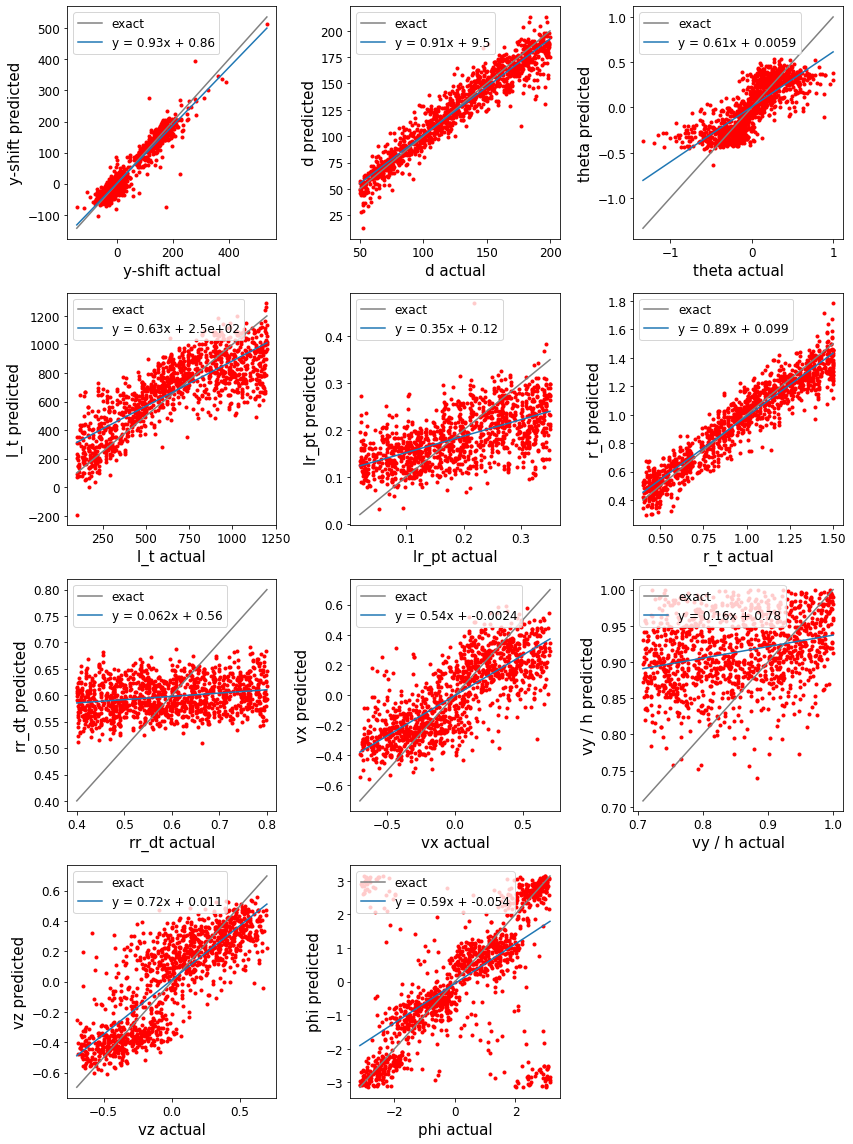

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

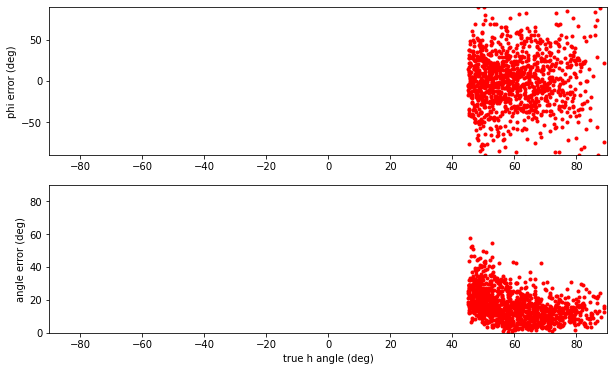

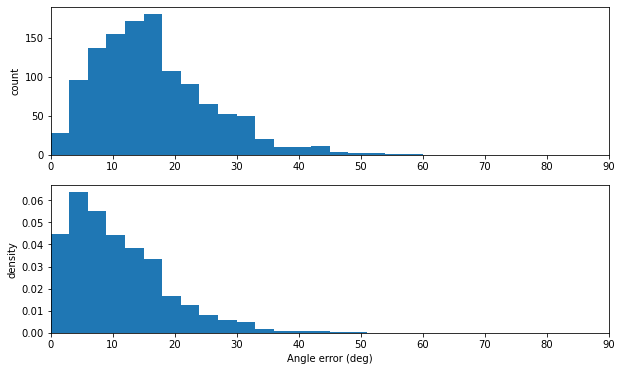

RMSE of angle: 19.0


In [13]:
if check_orient:
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

    bins = 30
    angle = np.arccos(cosine_similarity(y[:, orient_idx2], output[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 8))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (output[:, orient_idx2[1]] - y[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 90])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 90))
    plt.xlim([0, 90])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 90), density=True, weights=weights)
    plt.xlim([0, 90])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

### Perform on detailed model (Random cases)

In [14]:
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed.npz')  # summary statistics
# STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed_strch.npz')  # summary statistics

#### Ground truth

In [15]:
STATS = np.load(STATS_PATH)
summ_stats_test = STATS['x']
labels_true = STATS['y']
if direction_vec:
    dv = hphi2unitsphere(labels_true[:, orient_idx0])
    labels_true = np.hstack([np.delete(labels_true, orient_idx0, axis=1), dv, labels_true[:, [orient_idx0[1]]]])
if has_yshift:
    labels_true[:, ys_idx] = ys

FileNotFoundError: [Errno 2] No such file or directory: 'cell_inference/resources/simulation_data\\Reduced_Order_tuftsyn_trunkLR4_LactvCa_Loc5_restrict_h\\summ_stats_detailed.npz'

#### Prediction

In [ ]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(label_list):
    labels_pred[:, i] = org_scale(labels_pred[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    labels_pred[:, orient_idx1] = trivarnorm2unitsphere(labels_pred[:, orient_idx1])
    labels_pred = np.hstack([labels_pred, unitsphere2hphi(labels_pred[:, orient_idx1])[:, [1]]])

print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(labels_true[:, i], labels_pred[:, i])))

In [ ]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Detailed Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(labels_true[:, i], labels_pred[:, i], c='red', marker='.')
    m, b = np.polyfit(labels_true[:, i], labels_pred[:, i], 1)
    ax.plot(labels_true[:, i], m * labels_true[:, i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

In [ ]:
if check_orient:
    bins = 30
    angle = np.arccos(cosine_similarity(labels_true[:, orient_idx2], labels_pred[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 8))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (labels_pred[:, orient_idx2[1]] - labels_true[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(labels_true[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-90, 90])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 90])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 90))
    plt.xlim([0, 90])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 90), density=True, weights=weights)
    plt.xlim([0, 90])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)